In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
from dotenv import load_dotenv
import pandas as pd
import os

In [2]:

load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

In [3]:
spark = SparkSession.builder \
    .master("local[8]") \
    .appName("US Accidents") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile",key_filepath  ) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/02 14:13:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [5]:
# Read Parquet files from GCS
parquet_files = [
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2016/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2017/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2018/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2019/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2020/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2021/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2022/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2023/933c14c388864f19a17c514e311a69b1-0.parquet"
                ]

df_list = [spark.read.option("header", "true").option("inferSchema", "true").parquet(file) for file in parquet_files]

merged_df = df_list[0]
for df in df_list[1:]:
    merged_df = merged_df.unionAll(df)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
merged_df.describe()

In [17]:
from pyspark.sql.functions import count, col

# Count null values for each column
null_counts = merged_df.select([count(col(c)).alias(c) for c in merged_df.columns])

# Calculate total row count
total_rows = merged_df.count()

# Subtract non-null counts from total row count to get null counts for each column
for col_name in merged_df.columns:
    null_counts = null_counts.withColumn(col_name, total_rows - col(col_name))

# Display null value counts for each column
null_counts.show()


+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Description|Street|City|County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+
|  0|     0|       0|         0|       0|        0|        0|           0

In [29]:
# Calculate missing value percentages for each column
missing_value_percentages = null_counts.select(
    [(col(c) / total_rows * 100).alias(c + "_percentage") for c in merged_df.columns]
)

# Display missing value percentages for each column
missing_value_percentages.show()

+-------------+-----------------+-------------------+---------------------+-------------------+--------------------+--------------------+-----------------------+----------------------+------------------+--------------------+-----------------+----------------+------------------+-------------------------+------------------------+----------------------+-----------------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------+------------------+------------------+--------------------------+-------------------------+-------------------------+
|ID_percentage|Source_percentage|Severity_percentage|Start_Time_percentage|End_Time_percentage|Start_Lat_percentage|Start_Lng_percentage|Distance(mi)_percentage|Description_percentage| Street_percentage|     City_percentage|County_percentage|State_percentage|Country_percentage|Temperature(F)_percentage|Wind_Chill(F)_percentage|Humidity(%)_percentage|Pressure(in)_percentage|Vi

<Axes: >

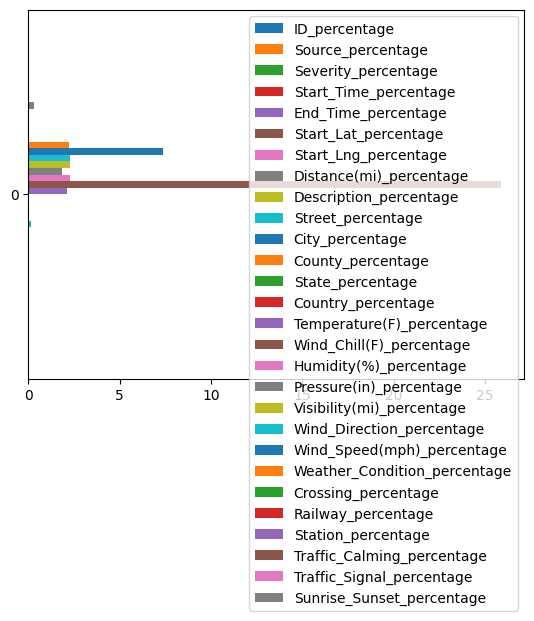

In [43]:
# Convert PySpark DataFrame to Pandas DataFrame
missing_value_percentages_pd = missing_value_percentages.toPandas()


# Filter out columns with non-zero null value percentages
missing_value_percentages_filtered_pd = missing_value_percentages_pd.loc[
    (missing_value_percentages_pd != 0).any(axis=1)
]

missing_value_percentages_filtered_pd.plot(kind='barh')

In [45]:
# Drop nulls
merged_df = merged_df.dropna()